# Tutorial 1: Simulation of lysozyme in water

Date: 3 Jun 2025

Auther: Heiley Wong

Referece: 

**Overview**
1. Download file
2. Remove crystal water
3. Generate input for GROMACS: `pdb2gmx`
4. Observe the output files
5. Define unit cell: `editconf`
6. Fill box with solvent: `solvate`
7. Add ions: `grompp` `genion`
8. Energy minimisation: `grompp` `mdrun`
9. Equilibration (NVT and NPT): `grompp` `mdrun`
10. MD production: `grompp` `mdrun`
11. Analysis of result (RMSD and radius of gyration)

# 1. Download file
Download pdb file of hen egg white lysozyme (PDB code 1AKI) from [RCSB website](https://www.rcsb.org/structure/1AKI). 

In [4]:
# Display the 3D structure
import nglview as ng
file_path = "1AKI.pdb"
show = ng.show_structure_file(file_path)
show

NGLWidget()

# 2. Remove crystal water
Water is labeled as HOH in pdb file. After removing them, verify that there is no missing atom. 

In [6]:
# Select lines without HOH
!grep -v HOH 1AKI.pdb > 1AKI_clean.pdb

In [7]:
# Count lines with "missing"
!grep -c MISSING 1AKI_clean.pdb

0


# 3. Generate input for GROMACS
Three files will be generated:
1. The topology for the molecule (topol.top): all the information necessary to define the molecule within a simulation, including nonbonded parameters (atom types and charges) and bonded parameters (bonds, angles, and dihedrals)
2. A position restraint file (posre.itp): defines force constant to keep atoms in place
3. A post-processed structure file (processed.gro): contains all the atoms defined within the force field

"OPLS-AA" is selected as the force field, and SPC/E water is selected as the solvent. 

[Summary of water model](https://water.lsbu.ac.uk/water/water_models.html)

In [ ]:
!gmx pdb2gmx -f 1AKI_clean.pdb -o 1AKI_processed.gro -water spce -ff "oplsaa"

In [10]:
!ls

1AKI_clean.pdb     1AKI.pdb           topol.top
1AKI_processed.gro posre.itp          tutorial-1.ipynb


# 4. Observe the output files
Topology file includess information about: 
- Force field `#include "oplsaa.ff/forcefield.itp"`
- Molecule name and exclusions for bonded neighbour `; Name       nrexcl\\
Protein_A    3`
- Atoms information: `[ atoms ]\\
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB\\
; residue   1 LYS rtp LYSH q +2.0`
- Bond

**Atom information**
- nr: Atom number
- type: Atom type
- resnr: Amino acid residue number
- residue: The amino acid residue name. Note that this residue was "LYS" in the PDB file; the use of .rtp entry "LYSH" indicates that the residue is protonated (the predominant state at neutral pH).
- atom: Atom name
- cgnr: Charge group number. Charge groups define units of integer charge; they aid in speeding up calculations
- charge: Self-explanatory
- The "qtot" descriptor is a running total of the charge on the molecule
- mass: Also self-explanatory
- typeB, chargeB, massB: Used for free energy perturbation (not discussed here)

Subsequent sections include [ bonds ], [ pairs ], [ angles ], and [ dihedrals ]. Some of these sections are self-explanatory (bonds, angles, and dihedrals). The parameters and function types associated with these sections are elaborated on in Chapter 5 of the GROMACS manual. Special 1-4 interactions are included under "pairs" (section 5.3.4 of the GROMACS manual).



In [ ]:
!cat topol.top

Position restrain files include 

In [ ]:
!cat posre.itp

# 5. Define unit cell

Cubic box is chosen, although rhombic dodecahedron is recommended, as its volume is ~71% of the cubic box of the same periodic distance, thus saving on the number of water molecules that need to be added to solvate the protein.

Specifications: 
- c: Center the protein
- d 1.0: Place protein at least 1.0 nm from box edge
- bt cubic: Define box time as cube

Since we will be using periodic boundary conditions, we must satisfy the minimum image convention. That is, a protein should never see its periodic image, otherwise the forces calculated will be spurious. Specifying a solute-box distance of 1.0 nm will mean that there are at least 2.0 nm between any two periodic images of a protein. This distance will be sufficient for just about any cutoff scheme commonly used in simulations.

**Periodic Boundary Condition**
PBC is used to study bulk properties. It consists of: 
- small box replicated in all directions
- a particle that leaves the box on oone side is replaced by an image particle that enters from the other side
- No walls and no surface particles

**Minimum Image Convention**
- Particles interact only with the closest periodic image of the other particles

In [ ]:
!gmx editconf -f 1AKI_processed.gro -o 1AKI_newbox.gro -c -d 1.0 -bt cubic

# 6. Fill box with solvent

Here we use `spc216.gro`, a generic equilibrated 3-point solvent model. SPC, SPC/E, or TIP3P water are all three-point water models. Output is `1AKI_solv.gro`. 

Specifications: 
- cp: Configuration of protein (output of the previous editconf step)
- cs: Configuration of solvent (part of gromacs installation)
- o: Output
- p: Processes the topology file

`solvate` keeps track of how many water molecules it has added and modifies the topology file. Note that if you use any other (non-water) solvent, solvate will not make these changes to your topology! 

In [ ]:
!gmx solvate -cp 1AKI_newbox.gro -cs spc216.gro -o 1AKI_solv.gro -p topol.top

In [19]:
!grep -A 10 "molecules" topol.top

[ molecules ]
; Compound        #mols
Protein_chain_A     1
SOL             10644


# 7. Add ions

`genion` reads through topology file and replace water molecules with specified ions. 

**Input**
The input is a run input file, produced by `grompp`. It process coordinate file and topology to generate an atomic-level input (.tpr), which contains all parameters of all atoms in the system. It requires a molecular dynamics parameter file (.mdp), nornally used to run energy minimisation or an MD simulation. The mdp file is downloaded from [here](http://www.mdtutorials.com/gmx/lysozyme/04_ions.html).

**Specifications**
- s: Structure/state file as input
- o: Output
- p: Process
- pname: Positive ion name (Capital letters)
- nname: Negative ion name (Capital letters)
- neutral: Final solution is neutral

- echo "SOL": Replace solution with protein

In [ ]:
# Create tpr file
!gmx grompp -f ions.mdp -c 1AKI_solv.gro -p topol.top -o ions.tpr

In [ ]:
# Pass to genion
!echo "SOL" | gmx genion -s ions.tpr -o 1AKI_solv_ions.gro -p topol.top -pname NA -nname CL -neutral

In [62]:
!grep -A 10 "molecules" topol.top

[ molecules ]
; Compound        #mols
Protein_chain_A     1
SOL         10636
CL               8


# 8. Energy minimisation

**Input**
We are once again going to use grompp to assemble the structure, topology, and simulation parameters into a binary input file (.tpr), but this time, instead of passing the .tpr to genion, we will run the energy minimization through the GROMACS MD engine, mdrun.

**Specification**
- v: Verbose
- deffnm em: Define output name as em.tpr

**Output**
- em.log: ASCII-text log file of the EM process
- em.edr: Binary energy file
- em.trr: Binary full-precision trajectory
- em.gro: Energy-minimized structure

In [ ]:
# Assemble tpr file
!gmx grompp -f minim.mdp -c 1AKI_solv_ions.gro -p topol.top -o em.tpr

In [ ]:
# Energy minimisation
!gmx mdrun -v -deffnm em

**Determine if EM run is successful**
1. Potential energy is negative, and (for a simple protein in water) on the order of 10^5-10^6, depending on the system size and number of water molecules.
2. Maximum force is smaller than that specified in `minim.mdp` ("emtol = 1000.0" = 1000 kJ mol^-1 nm^-1). It is possible to arrive at a reasonable Epot with Fmax > emtol. If this happens, your system may not be stable enough for simulation. Evaluate why it may be happening, and perhaps change your minimization parameters (integrator, emstep, etc).

In [87]:
# Double check if potential energy is negative
!tail -n10 em.log

Potential Energy  = -5.8805606e+05
Maximum force     =  8.9496838e+02 on atom 736
Norm of force     =  2.0414467e+01

    D O M A I N   D E C O M P O S I T I O N   S T A T I S T I C S

 av. #atoms communicated per step for force:  2 x 0.0

Finished mdrun on rank 0 Mon Jun  2 20:12:38 2025



In [ ]:
# Print out potential energy throughout EM
# !pip install gmxvg
!echo "10 0"| gmx energy -f em.edr -o potential.xvg

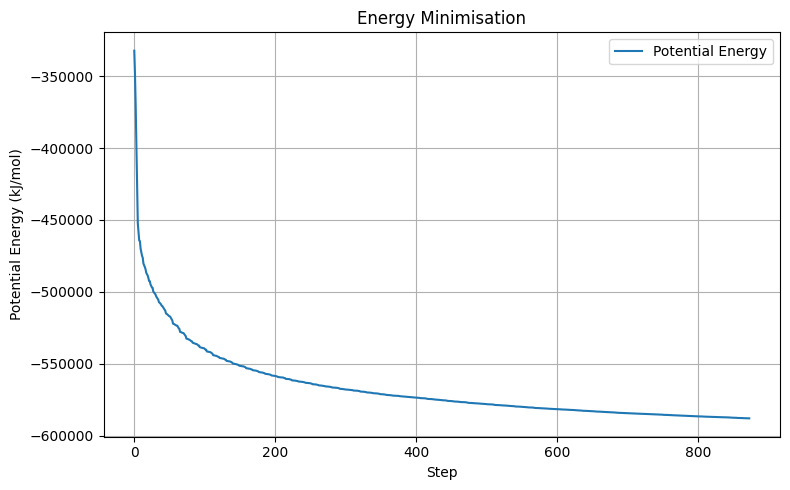

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Read the data, ignoring comments and metadata lines
time = []
potential = []

with open("potential.xvg") as file:
    for line in file:
        if line.startswith(('#', '@')):
            continue  # skip comments and metadata
        parts = line.strip().split()
        time.append(float(parts[0]))
        potential.append(float(parts[1]))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(time, potential, label="Potential Energy")
plt.xlabel("Step")
plt.ylabel("Potential Energy (kJ/mol)")
plt.title("Energy Minimisation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Equilibration

Purpose: 
- Optimise solvent with solute (protein) 
- Optimise solvemtn within itsellf
- Bring to desired temperatre
- Bring to proper oreientation of protein
- Bring to proper denity

**First phase: NVT ensemble**

Constant number of partibles, volume and temperature. Around 50-100 ps. 
mdp file is from [here](http://www.mdtutorials.com/gmx/lysozyme/06_equil.html)

Take note of a few parameters in the .mdp file:

- gen_vel = yes: Initiates velocity generation. Using different random seeds (gen_seed) gives different initial velocities, and thus multiple (different) simulations can be conducted from the same starting structure.
- tcoupl = V-rescale: The velocity rescaling thermostat is an improvement upon the Berendsen weak coupling method, which did not reproduce a correct kinetic ensemble.
- pcoupl = no: Pressure coupling is not applied. 

In [ ]:
# Run equilibration under NVT ensemble
!gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

!gmx mdrun -deffnm nvt

In [ ]:
!echo "16 0" | gmx energy -f nvt.edr -o temperature.xvg

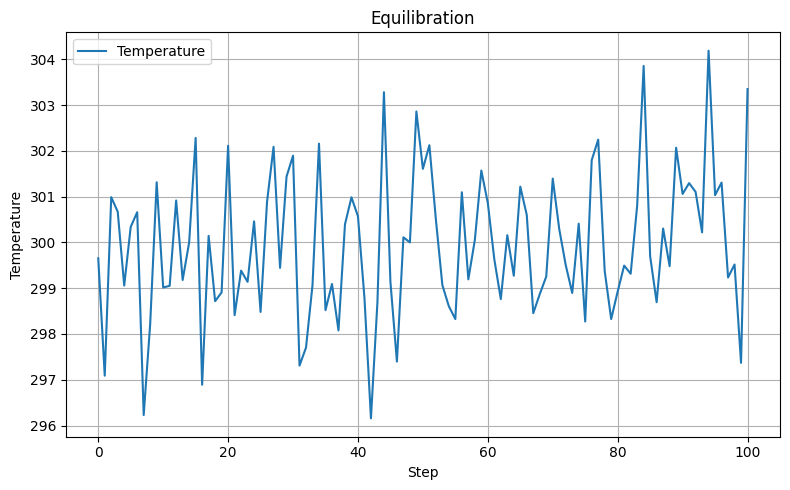

In [149]:
time = []
potential = []

with open("temperature.xvg") as file:
    for line in file:
        if line.startswith(('#', '@')):
            continue  # skip comments and metadata
        parts = line.strip().split()
        time.append(float(parts[0]))
        potential.append(float(parts[1]))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(time, potential, label="Temperature")
plt.xlabel("Step")
plt.ylabel("Temperature")
plt.title("Equilibration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Second phase: NPT ensemble**

**Input**
- c: Input gro file found [here](http://www.mdtutorials.com/gmx/lysozyme/07_equil2.html)

In [ ]:
!gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

!gmx mdrun -deffnm npt

In [ ]:
!echo "18 0" | gmx energy -f npt.edr -o pressure.xvg

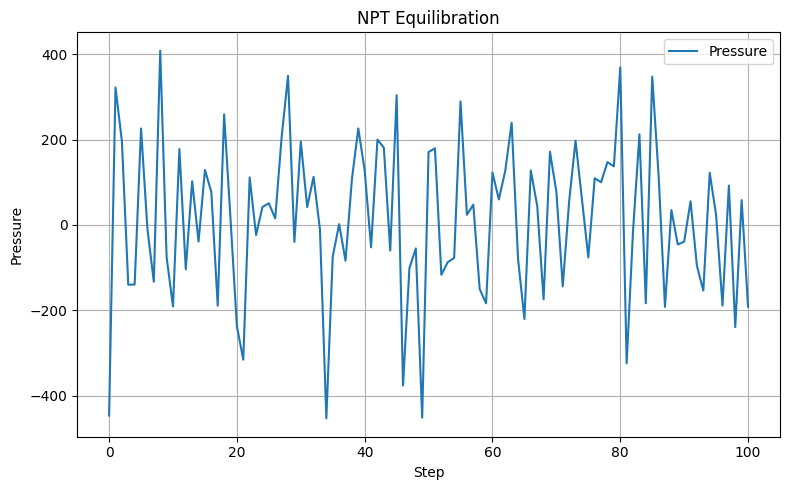

In [10]:
time = []
potential = []

with open("pressure.xvg") as file:
    for line in file:
        if line.startswith(('#', '@')):
            continue  # skip comments and metadata
        parts = line.strip().split()
        time.append(float(parts[0]))
        potential.append(float(parts[1]))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(time, potential, label="Pressure")
plt.xlabel("Step")
plt.ylabel("Pressure")
plt.title("NPT Equilibration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!echo "24 0" | gmx energy -f npt.edr -o density.xvg

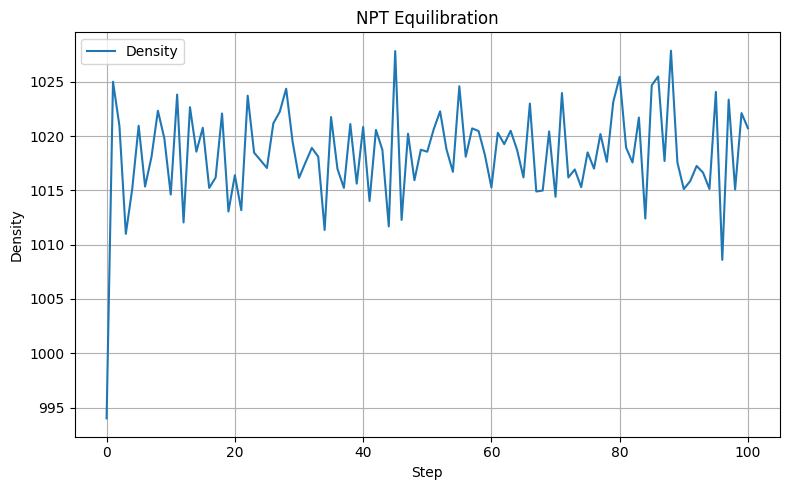

In [14]:
time = []
potential = []

with open("density.xvg") as file:
    for line in file:
        if line.startswith(('#', '@')):
            continue  # skip comments and metadata
        parts = line.strip().split()
        time.append(float(parts[0]))
        potential.append(float(parts[1]))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(time, potential, label="Density")
plt.xlabel("Step")
plt.ylabel("Density")
plt.title("NPT Equilibration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Produce MD

Input mdp file from [here](http://www.mdtutorials.com/gmx/lysozyme/08_MD.html). We will first understand the molecular dynamics parameter defined in the file: 
- Integrator=md: Leap-frog integrator [1]
    - $r(t+\Delta t)=r(t)+\Delta t v(t+\frac{1}{2}\Delta t)$
    - $v(t+\frac{1}{2}\Delta t)=v(t-\frac{1}{2}\Delta t)+\Delta t a(t)$
- nsteps
- dt

In [5]:
!cat md.mdp

title                   = OPLS Lysozyme NPT equilibration 
; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 500000    ; 2 * 500000 = 1000 ps (1 ns)
dt                      = 0.002     ; 2 fs
; Output control
nstxout                 = 0         ; suppress bulky .trr file by specifying 
nstvout                 = 0         ; 0 for output frequency of nstxout,
nstfout                 = 0         ; nstvout, and nstfout
nstenergy               = 5000      ; save energies every 10.0 ps
nstlog                  = 5000      ; update log file every 10.0 ps
nstxout-compressed      = 5000      ; save compressed coordinates every 10.0 ps
compressed-x-grps       = System    ; save the whole system
; Bond parameters
continuation            = yes       ; Restarting after NPT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accura

In [ ]:
!gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_0_1.tpr

In [2]:
# MD run
!gmx mdrun -v -deffnm md_0_1 

                  :-) GROMACS - gmx mdrun, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Downloads/gmx-tutorial
Command line:
  gmx mdrun -v -deffnm md_0_1


Back Off! I just backed up md_0_1.log to ./#md_0_1.log.3#
Reading file md_0_1.tpr, VERSION 2025.1-Homebrew (single precision)
Changing nstlist from 10 to 50, rlist from 1 to 1.117

Using 1 MPI thread
Using 8 OpenMP threads 


Back Off! I just backed up md_0_1.xtc to ./#md_0_1.xtc.3#

Back Off! I just backed up md_0_1.edr to ./#md_0_1.edr.3#
starting mdrun 'LYSOZYME in water'
500000 steps,   1000.0 ps.
step 499900, remaining wall clock time:     2 s          ish Wed Jun  4 17:15:07 2025, will finish Wed Jun  4 17:32:13 2025Wed Jun  4 17:34:29 2025Wed Jun  4 17:38:00 2025Wed Jun  4 20:19:01 2025, will finish Wed Jun  4 20:14:45 2025Wed Jun  4 20:00:53 2025, will finish Wed Jun  4 20:17:17 2025Wed Jun  4 20:03:

# 11. Analysis of trajectory

**Calculation of RMSD**

To understand the structural stability, root mean square deviation is calculated, which measures the average deviation in atomic positions between two structures. RMSD levels off to ~0.1 nm (1 Ã…), indicating that the structure is very stable. 

In [ ]:
!echo "1 0"| gmx trjconv -s md_0_1.tpr -f md_0_1.xtc -o md_0_1_noPBC.xtc -pbc mol -center

In [ ]:
!echo "4 4"|gmx rms -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg -tu ns 

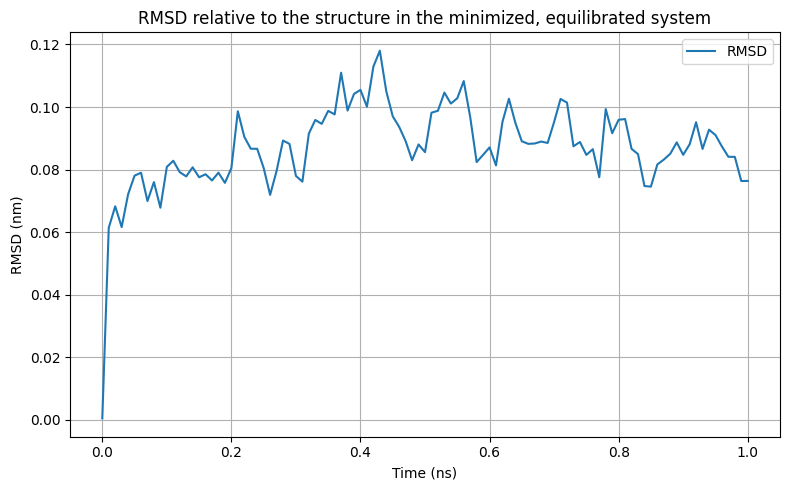

In [8]:
time = []
potential = []

with open("rmsd.xvg") as file:
    for line in file:
        if line.startswith(('#', '@')):
            continue  # skip comments and metadata
        parts = line.strip().split()
        time.append(float(parts[0]))
        potential.append(float(parts[1]))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(time, potential, label="RMSD")
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (nm)")
plt.title("RMSD relative to the structure in the minimized, equilibrated system")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Radius of gyration**

Radius of gyration of a protein is a measure of its compactness. If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time.

We can see from the reasonably invariant Rg values that the protein remains very stable, in its compact (folded) form over the course of 1 ns at 300 K. 

In [ ]:
!echo "1" | gmx gyrate -s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg

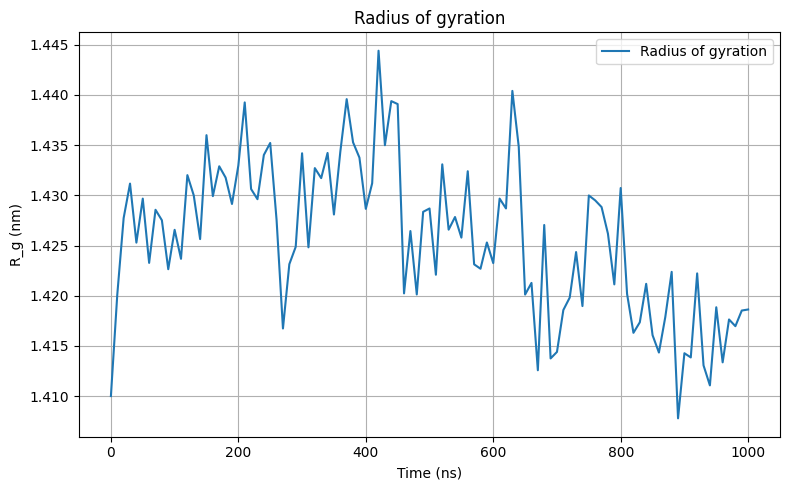

In [61]:
time = []
potential = []

with open("gyrate.xvg") as file:
    for line in file:
        if line.startswith(('#', '@')):
            continue  # skip comments and metadata
        parts = line.strip().split()
        time.append(float(parts[0]))
        potential.append(float(parts[1]))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(time, potential,label = "Radius of gyration")
plt.xlabel("Time (ns)")
plt.ylabel("R_g (nm)")
plt.title("Radius of gyration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**RMSD-based Clustering**
1. Prompt
- Call the program with gmx
- cluster: Select the cluster module
- f flag and provide the entire trajectory file (md.xtc)
- s flag is used to provide the tpr file of the run (md.tpr)
- method flag is used to select the method we want to use (gromos in our case)
- cutoff: We can choose the cutoff value in nm (0.15) 
- b: select the starting point from the analysis depending on the equilibration of your system via -b
- g flag: name the file listing all clusters and their members (by default cluster.log)
- cl: writes the representative structure for each cluster in a pdb file (clusters.pdb)
2. Select a group for least squares fit and RMSD calculation
3. Select the part of the system that you want to include in the output file clusters.pdb
4. Read the number of clusters & representatnive frame of each cluster in `cluster.log`
5. Visualise the structure using `cluster.pdb`

In [2]:
!echo "3 1" | gmx cluster -f md_0_1.xtc -s md_0_1.tpr -method gromos -cutoff 0.15 -cl -dt 10 

                 :-) GROMACS - gmx cluster, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-1
Command line:
  gmx cluster -f md_0_1.xtc -s md_0_1.tpr -method gromos -cutoff 0.15 -cl -dt 10


Back Off! I just backed up cluster.log to ./#cluster.log.5#
Using gromos method for clustering
Reading file md_0_1.tpr, VERSION 2025.1-Homebrew (single precision)
Reading file md_0_1.tpr, VERSION 2025.1-Homebrew (single precision)

Select group for least squares fit and RMSD calculation:
Group     0 (         System) has 33876 elements
Group     1 (        Protein) has  1960 elements
Group     2 (      Protein-H) has  1001 elements
Group     3 (        C-alpha) has   129 elements
Group     4 (       Backbone) has   387 elements
Group     5 (      MainChain) has   517 elements
Group     6 (   MainChain+Cb) has   634 elements
Group     7 (  